# Tech Challenge - Fase 4: Deep Learning e IA
**Objetivo:** Desenvolver um modelo preditivo utilizando redes neurais **LSTM (Long Short Term Memory)** para prever o valor de fechamento das ações de uma empresa. O projeto abrange desde o pré-processamento de séries temporais até a exportação do modelo para deploy em uma API.

**Autor:** Noah Diunkz

**Ticker Utilizado:** AAPL (Apple Inc.)

## 1. Configuração do Ambiente
Nesta etapa, realizo a importação das bibliotecas necessárias para manipulação de dados (`Pandas`, `NumPy`), visualização (`Matplotlib`), métricas (`Scikit-Learn`) e a construção da rede neural (`TensorFlow/Keras`).

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Silenciar avisos do TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 2. Carregamento e Exploração dos Dados
Utilizo o arquivo CSV gerado previamente pelo script de ingestão. Como o `yfinance` exporta dados com cabeçalhos múltiplos (MultiIndex), realizo o tratamento para extrair exclusivamente a série temporal de preços de fechamento (**Close**).

In [16]:
ticker = "AAPL"
csv_path = f'../data/{ticker}_history.csv'

# Trata o formato MultiIndex do yfinance (pula o cabeçalho de Ticker)
df = pd.read_csv(csv_path, header=[0, 1], index_col=0, parse_dates=True)

# Extrai os valores de fechamento e ajusta o formato para o Scaler
raw_data = df['Close'][ticker].values.reshape(-1, 1)

print(f"Dataset carregado com sucesso. Total de registros: {len(raw_data)}")

Dataset carregado com sucesso. Total de registros: 1647


## 3. Engenharia de Atributos e Normalização
Aplico o **MinMaxScaler** para transformar os preços em uma escala entre 0 e 1. Estruturo os dados em **janelas temporais** de 60 dias para prever o dia seguinte.

In [17]:
# Normalização 0 a 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

# Criação das janelas (60 dias anteriores para prever o t+1)
window_size = 60 
X, y = [], []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Formato exigido pela LSTM: [Amostras, Passos de Tempo, Features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split 80% treino / 20% teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 4. Arquitetura do Modelo e Treinamento
Defino uma rede com duas camadas LSTM e Dropout para evitar overfitting. O treinamento é realizado por 15 épocas.

In [18]:
# Utilizo a abordagem recomendada pelas versões recentes do Keras,
# definindo explicitamente a camada de Input.

model = tf.keras.Sequential([
    # Definição explícita da forma de entrada (60 dias, 1 feature)
    tf.keras.layers.Input(shape=(X.shape[1], 1)),
    
    # Primeira camada LSTM
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    
    # Segunda camada LSTM
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    
    # Camadas de saída
    tf.keras.layers.Dense(units=25),
    tf.keras.layers.Dense(units=1) 
])

# Compilação com otimizador Adam
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error')

# Treinamento salvando o histórico para análise posterior
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0104 - val_loss: 0.0022
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.5701e-04 - val_loss: 0.0013
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.0955e-04 - val_loss: 6.3064e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.8532e-04 - val_loss: 0.0012
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.6737e-04 - val_loss: 0.0013
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 5.7383e-04
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 7.6862e-04
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.4216e-04 - val_loss: 0.0016
Epoch 12/20
40/40 ━━━━━━━━━━━━━

## 4.1. Visualização do Aprendizado (Curvas de Erro)
Nesta etapa, utilizo os dados armazenados na variável `history` para gerar o gráfico de perda (Loss). Isso me permite verificar se o número de épocas foi adequado e se o modelo apresenta sinais de *overfitting* ou *underfitting*.

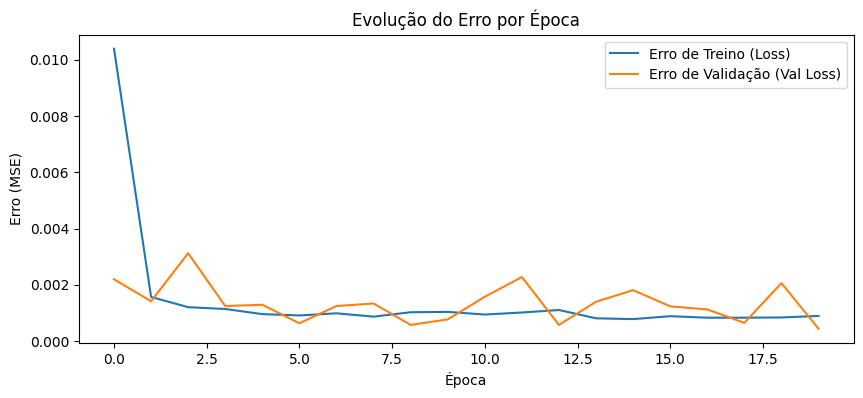

In [19]:
# Gerando o gráfico de evolução do erro
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Erro de Treino (Loss)')
plt.plot(history.history['val_loss'], label='Erro de Validação (Val Loss)')
plt.title('Evolução do Erro por Época')
plt.xlabel('Época')
plt.ylabel('Erro (MSE)')
plt.legend()
plt.show()

## 5. Avaliação de Performance e Visualização
Realizo as previsões no conjunto de teste e inverto a normalização para comparar com os preços reais.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
--- MÉTRICAS DE PERFORMANCE ---
MAE (Erro Médio): 3.13
RMSE (Raiz do Erro Quadrático): 4.17


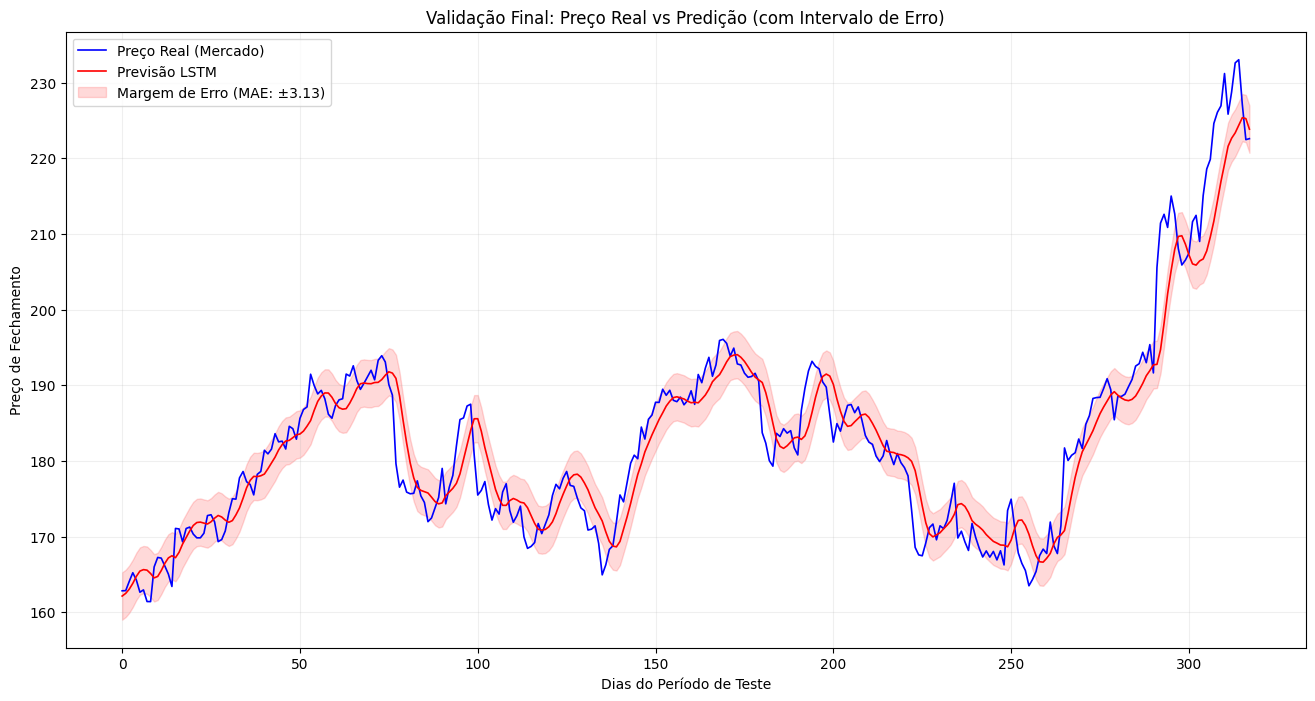

In [20]:
# 1. Realizo as predições e volto para a escala original (Dólares/Reais)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 2. Cálculo das métricas de erro
mae = mean_absolute_error(y_test_real, predictions)
rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
print(f"--- MÉTRICAS DE PERFORMANCE ---")
print(f"MAE (Erro Médio): {mae:.2f}")
print(f"RMSE (Raiz do Erro Quadrático): {rmse:.2f}")

# 3. Definição da Banda de Erro (Margem de segurança baseada no MAE)
upper_bound = predictions.flatten() + mae
lower_bound = predictions.flatten() - mae

# 4. Gráfico Real vs Predição com Banda de Erro
plt.figure(figsize=(16, 8))

# Plot do preço real
plt.plot(y_test_real, color='blue', label='Preço Real (Mercado)', linewidth=1.2)

# Plot da previsão
plt.plot(predictions, color='red', label='Previsão LSTM', linewidth=1.2)

# Preenchimento da área de erro (Sombreado)
plt.fill_between(
    range(len(predictions)), 
    lower_bound, 
    upper_bound, 
    color='red', 
    alpha=0.15, 
    label=f'Margem de Erro (MAE: ±{mae:.2f})'
)

plt.title('Validação Final: Preço Real vs Predição (com Intervalo de Erro)')
plt.xlabel('Dias do Período de Teste')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

## 6. Exportação de Artefatos
Salvo o modelo e o scaler para uso na API.

In [21]:
# Crio o diretório se não existir e salvo o modelo no formato nativo .keras
# O scaler permanece em .pkl para ser lido pelo joblib na API.

os.makedirs('../app/saved_models', exist_ok=True)

# Alterado para .keras para evitar o aviso de formato legado (legacy)
model.save('../app/saved_models/lstm_model.keras')

# Exportação do objeto scaler
joblib.dump(scaler, '../app/saved_models/scaler.pkl')

print("Artefatos salvos com sucesso no formato nativo!")

Artefatos salvos com sucesso no formato nativo!
